In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# --- 1. Define Paths and Load Data ---

# Define the path to the directory containing your CSV and Patients_CT folder
current_dir = os.getcwd()  # Gets current working directory
project_root = os.path.dirname(current_dir)  # Go up one level to project root
print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")

# Path to CSV
csv_path = os.path.join(project_root, 'data', 'raw', 'hemorrhage_diagnosis.csv')

# Path to CT images
image_base_dir = os.path.join(project_root, 'data', 'raw', 'Patients_CT')

# Verify paths exist
print(f"CSV path exists: {os.path.exists(csv_path)}")
print(f"Images dir exists: {os.path.exists(image_base_dir)}")

Current directory: c:\Users\khadk\OneDrive - Wright State University\Summer 2025\Machine Learning\Final Project\Project_Files\Intercranial-Hemorrhage-Detection\notebooks
Project root: c:\Users\khadk\OneDrive - Wright State University\Summer 2025\Machine Learning\Final Project\Project_Files\Intercranial-Hemorrhage-Detection
CSV path exists: True
Images dir exists: True


In [3]:
# Load the data
df = pd.read_csv(csv_path)

# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv(csv_path)
    print("Successfully loaded hemmorrhage_diagnosis.csv")
except FileNotFoundError:
    print(f"Error: The file was not found at {csv_path}")
    # Exit or handle the error appropriately in a real script
    df = pd.DataFrame()
# Display the first few rows of the DataFrame
print("DataFrame head:")
print(df.head())

Successfully loaded hemmorrhage_diagnosis.csv
DataFrame head:
   PatientNumber  SliceNumber  Intraventricular  Intraparenchymal  \
0             49            1                 0                 0   
1             49            2                 0                 0   
2             49            3                 0                 0   
3             49            4                 0                 0   
4             49            5                 0                 0   

   Subarachnoid  Epidural  Subdural  No_Hemorrhage  Fracture_Yes_No  
0             0         0         0              1                0  
1             0         0         0              1                0  
2             0         0         0              1                0  
3             0         0         0              1                0  
4             0         0         0              1                0  


In [4]:
# --- 2. Prepare the DataFrame ---

def get_patient_folder(patient_num):
    """Convert patient number to 3-digit folder name"""
    return f"{int(patient_num):03d}"  # 49 → '049'

try:
    df = pd.read_csv(csv_path)
    print("Successfully loaded hemorrhage_diagnosis.csv")
    
    if not df.empty:
        # Create a simple binary label
        hemorrhage_cols = ['Intraventricular', 'Intraparenchymal', 'Subarachnoid', 'Epidural', 'Subdural']
        df['Hemorrhage'] = df[hemorrhage_cols].any(axis=1).astype(int)

        # Create the full filepath for each image slice with 3-digit format
        df['filepath'] = df.apply(
            lambda row: os.path.join(
                image_base_dir,
                get_patient_folder(row['PatientNumber']),
                'brain',
                f"{row['SliceNumber']}.jpg"
            ),
            axis=1
        )

        # Verify paths
        df['path_exists'] = df['filepath'].apply(os.path.exists)
        print(f"\nPath validation:")
        print(f"{df['path_exists'].sum()}/{len(df)} paths exist")
        
        # Separate into two groups for analysis
        hemorrhage_df = df[df['Hemorrhage'] == 1]
        normal_df = df[df['Hemorrhage'] == 0]

        print(f"\nTotal slices found: {len(df)}")
        print(f"Hemorrhage slices found: {len(hemorrhage_df)}")
        print(f"Normal slices found: {len(normal_df)}")

except FileNotFoundError:
    print(f"Error: The file was not found at {csv_path}")
    df = pd.DataFrame()
except Exception as e:
    print(f"Error loading data: {str(e)}")
    df = pd.DataFrame()

Successfully loaded hemorrhage_diagnosis.csv

Path validation:
2501/2501 paths exist

Total slices found: 2501
Hemorrhage slices found: 318
Normal slices found: 2183



--- Displaying 5 sample Hemorrhage images ---


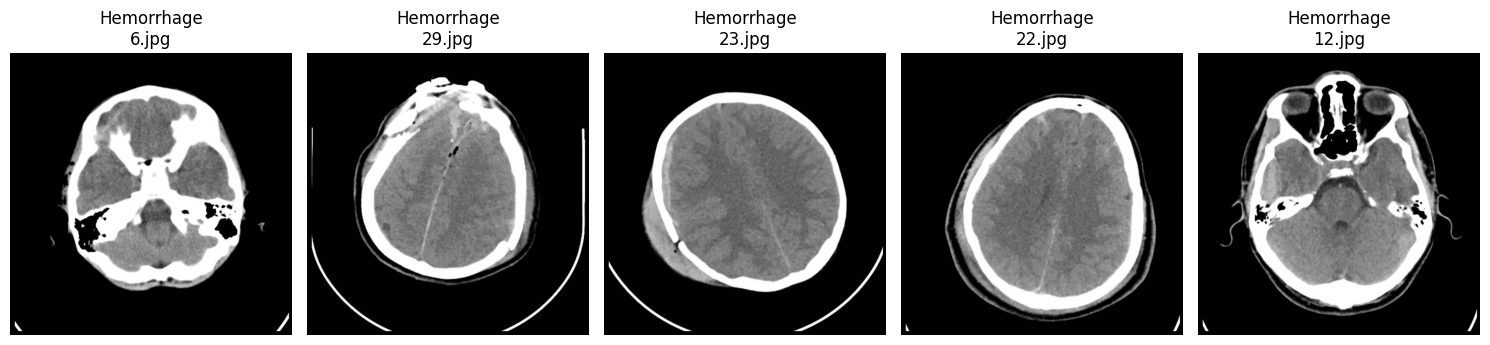


--- Displaying 5 sample Normal images ---


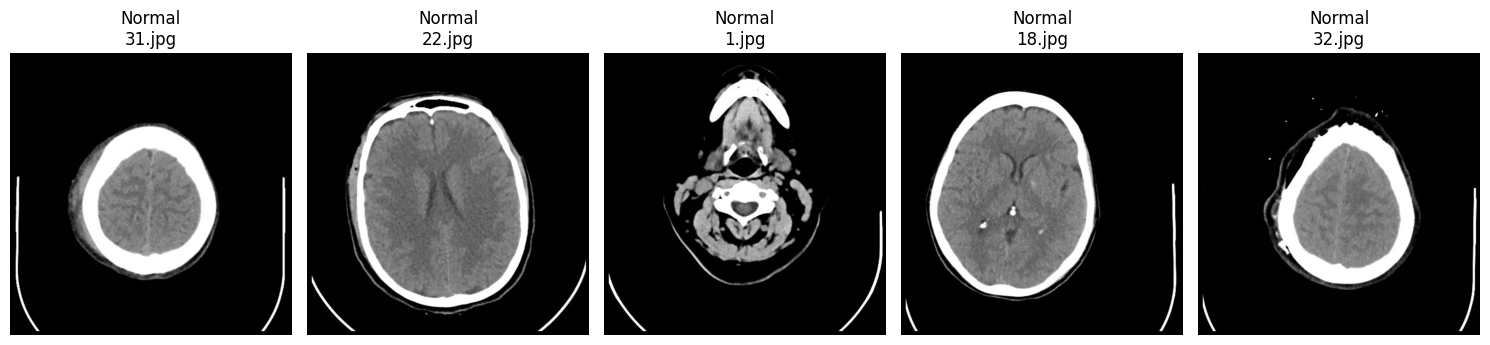

In [5]:
# --- 3. Visualize Sample Images ---

def plot_samples_from_df(dataframe, label, num_samples=5):
    """Loads and plots a few sample images from the DataFrame."""
    print(f"\n--- Displaying {num_samples} sample {label} images ---")
    
    # Get a random sample of filepaths from the DataFrame
    sample_paths = dataframe['filepath'].sample(n=num_samples, replace=False)
    
    plt.figure(figsize=(15, 4))
    for i, img_path in enumerate(sample_paths):
        plt.subplot(1, num_samples, i + 1)
        try:
            img = Image.open(img_path).convert('L') # Convert to grayscale
            plt.imshow(np.array(img), cmap='gray')
            plt.title(f"{label}\n{os.path.basename(img_path)}")
            plt.axis('off')
        except FileNotFoundError:
            plt.title("Image Not Found")
            print(f"Warning: Image not found at {img_path}")
            
    plt.tight_layout()
    plt.show()

# Plot samples from each class if the DataFrame was loaded
if not df.empty:
    plot_samples_from_df(hemorrhage_df, "Hemorrhage", num_samples=5)
    plot_samples_from_df(normal_df, "Normal", num_samples=5)

In [6]:
# --- 4. Check Image Properties ---

def check_image_properties(dataframe, num_check=20):
    """Checks dimensions and modes for a few images from the DataFrame."""
    print(f"\n--- Checking properties of {num_check} random images ---")
    
    # Ensure we don't try to sample more images than exist
    num_to_sample = min(num_check, len(dataframe))
    if num_to_sample == 0:
        print("No images to check.")
        return
        
    sample_paths = dataframe['filepath'].sample(n=num_to_sample, replace=False)
    
    dimensions = set()
    for img_path in sample_paths:
        try:
            with Image.open(img_path) as img:
                dimensions.add(img.size) # (width, height)
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_path}")
            
    print(f"Unique dimensions found in sample: {list(dimensions)}")
    if len(dimensions) > 1:
        print("Warning: Images may have inconsistent dimensions! Resizing will be necessary.")

# Check properties using the full DataFrame
if not df.empty:
    check_image_properties(df, num_check=1000)


--- Checking properties of 1000 random images ---
Unique dimensions found in sample: [(650, 650)]


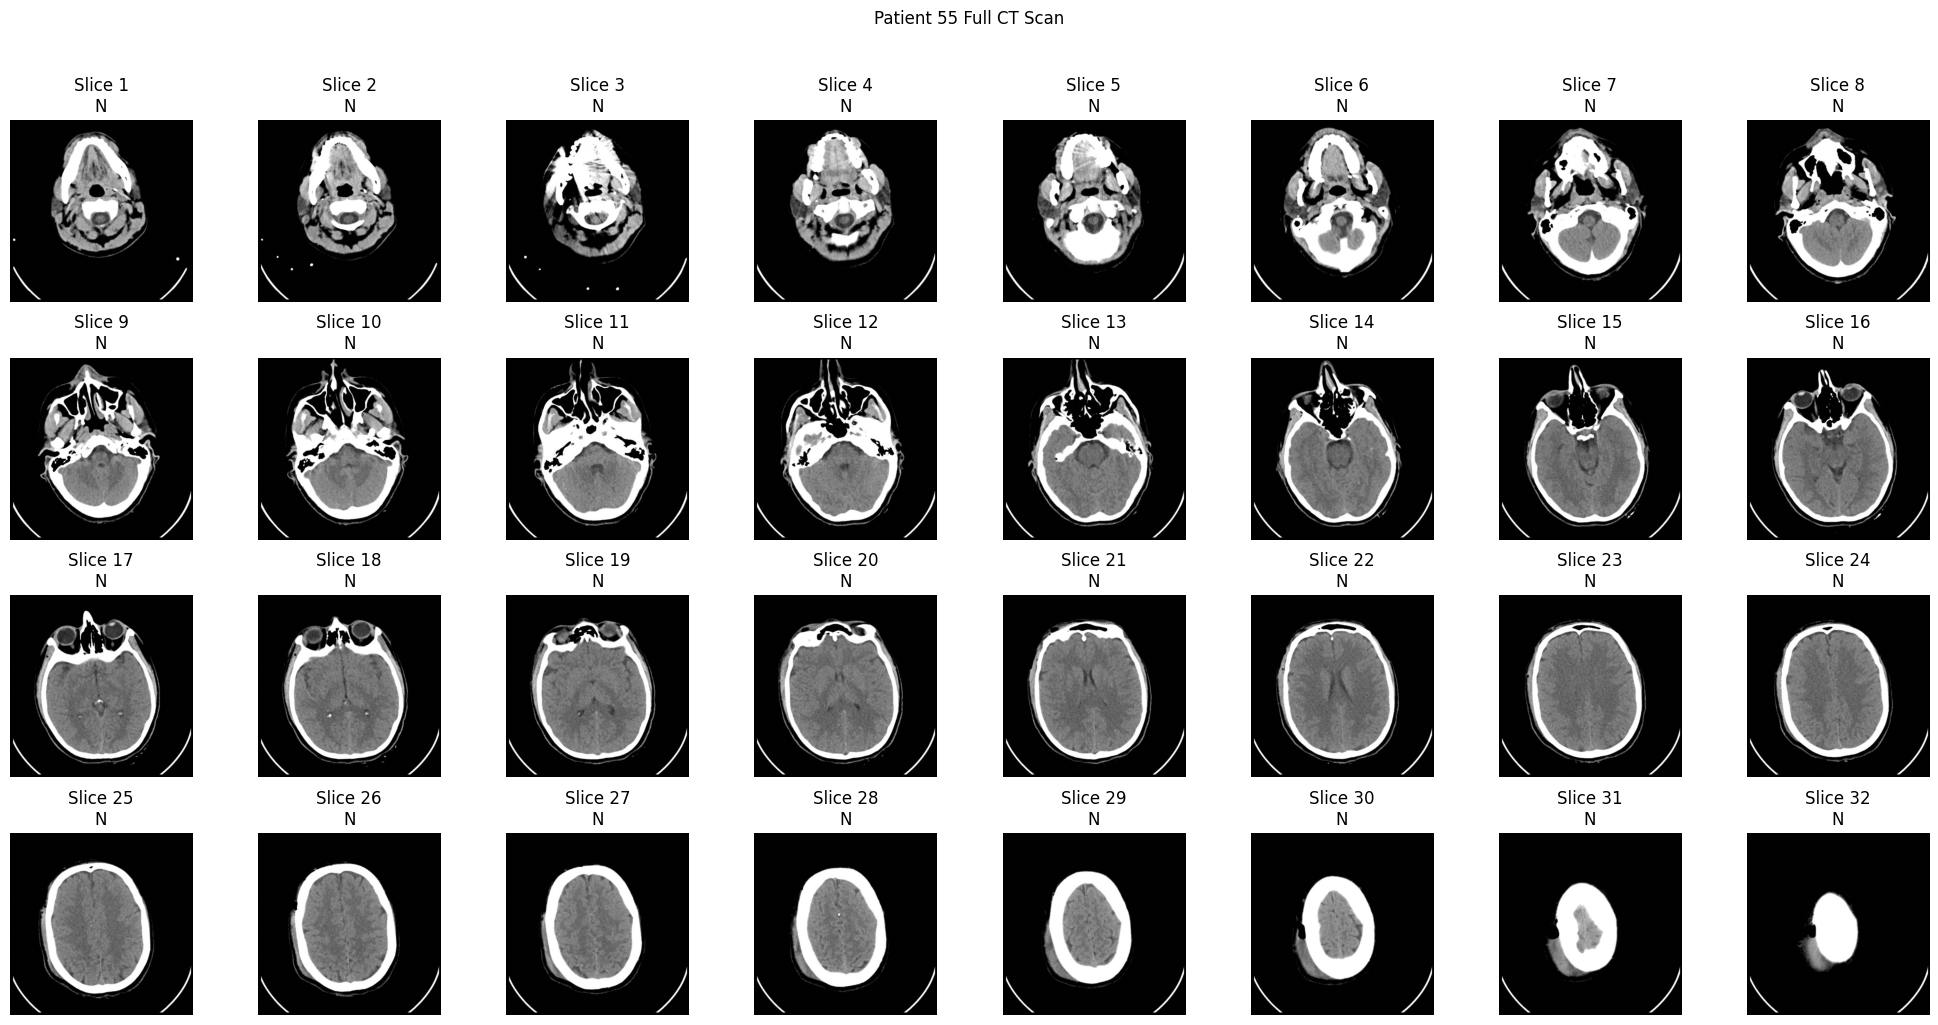

In [ ]:
# --- 5. Plot Full CT Scan for a Patient ---
def plot_patient_scan(patient_num):
    """Plot all slices for one patient in a grid"""
    patient_slices = df[df['PatientNumber'] == patient_num]
    
    # Create figure
    cols = 8  # Images per row
    rows = int(np.ceil(len(patient_slices)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows*2.5))
    
    for idx, (_, row) in enumerate(patient_slices.iterrows()):
        ax = axes.flat[idx]
        img = Image.open(row['filepath'])
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Slice {row['SliceNumber']}\n{'H' if row['Hemorrhage'] else 'N'}")
        ax.axis('off')
    
    # Hide empty axes
    for ax in axes.flat[len(patient_slices):]:
        ax.axis('off')
    
    plt.suptitle(f"Patient {patient_num} Full CT Scan", y=1.02)
    plt.tight_layout()
    plt.show()

plot_patient_scan(49)  # Try with different patient numbers

Just checking both of the brain and bone fractures

In [8]:
def prepare_dataframe(df):
    """Adds filepaths for both brain and bone windows"""
    # Convert patient numbers to 3-digit format
    df['patient_folder'] = df['PatientNumber'].apply(lambda x: f"{int(x):03d}")
    
    # Create paths for both window types
    df['brain_path'] = df.apply(
        lambda row: os.path.join(image_base_dir, row['patient_folder'], 
                               'brain', f"{row['SliceNumber']}.jpg"),
        axis=1
    )
    
    df['bone_path'] = df.apply(
        lambda row: os.path.join(image_base_dir, row['patient_folder'], 
                               'bone', f"{row['SliceNumber']}.jpg"),
        axis=1
    )
    
    # Verify paths
    df['brain_exists'] = df['brain_path'].apply(os.path.exists)
    df['bone_exists'] = df['bone_path'].apply(os.path.exists)
    
    print(f"\nPath verification:")
    print(f"Brain windows: {df['brain_exists'].sum()}/{len(df)} exist")
    print(f"Bone windows: {df['bone_exists'].sum()}/{len(df)} exist")
    
    return df

# Usage
if not df.empty:
    df = prepare_dataframe(df)


Path verification:
Brain windows: 2501/2501 exist
Bone windows: 2500/2501 exist
